<div dir='rtl'>
<h1>پروژه هفتم علوم اعصاب محاسباتی</h1>
<br/>
    - <font color='red'>با توجه به تغییرات عمده اعمال شده در طراحی و رابط کاربری فریم‌ورک، در این تمرین کدها حذف نشده‌اند تا لطف کنید و در بازخورد، درباره این رابط و ساختار نیز بازخورد دهید. با تشکر.</font>
<br/>
    - با توجه به حجم زیاد نمودار‌های هر بخش، تعداد زیادی از آزمایش‌های محکوم به شکست در این گزارش آورده نشده است. برخی از آن‌ها که دارای نکته قابل توجه بوده‌اند، در بخش مربوطه مورد اشاره قرار گرفته‌اند اما نمودار یا نمایشی از آن‌ها وجود ندارد و تمرکز این گزارش بر بررسی تأثیر پارامتر‌ها قرار گرفته است.
    <br/>
    - در فاز قبل، تأثیرات پارامتر‌های stdp بررسی شد. بنابراین در این گزارش به بررسی مجدد آن‌ها نخواهیم پرداخت و فقط به تأثیرات ناشی از نوروماژولاتور‌ها خواهیم پرداخت.
    <br/>
    - مقداردهی اولیه پارامتر‌ها و پارامتر‌های ثابت در تمام آزمایش‌ها، بر مبنای بهترین مشاهده قبل از مکتوب سازی گزارش است.
    <font color='red'>پیدا کردن این مقادیر با روش آزمون و خطا، ۲۰ ساعت آزمایش زمان برده است. برای حفظ حجم گزارش، از بررسی این آزمون‌ها خودداری می‌شود.</font>
    <br/>
    - کد‌ها فقط در ابتدای گزارش زیاد هستند.
    <br/>
    <br/>
    <br/>
    نکته درمورد پیاده‌سازی: ماژول پاداش توسط دو بخش مدل شده است. یک بافت نوروماژولاتوری که رفتاری مانند جمعیت نورونی دارد (در واقعیت نیز نورون‌های نوروماژولاتوری این وظیفه را برعهده دارند) و یک (یا چند) آکسون که نوروماژولاتور‌ها را به سیناپس‌ها می‌رسانند. این آکسون‌ها می‌توانند تأخیرات را اعمال کنند اما در این فاز تنها با پارامتر scale آن‌ها بازی خواهد شد که به سادگی میزان پاداش را در مقداری ضرب می‌کند. همچنین محاسبه میزان پاداش بیرون شبکه انجام می‌شود، چرا که این قسمت مسئله به مسئله تغییر خواهد کرد، بنابراین پیاده سازی آن در شبکه چندان کارا نبود. این پاداش محاسبه شده مستقیما به بافت نوروماژولاتوری ارائه خواهد شد.
</div>

<div dir='rtl'>
<h2>0. فهرست مطالب</h2>
<ol>
    <li><a href="#1">ساخت شبکه</a></li>
    <li><a href="#2">بررسی طرح آزمایش‌ها</a></li>
    <li><a href="#3">روش RSTDP</a></li>
    <li><a href="#4">تأثیر پارامتر ثابت زمانی تغییرات دوپامین در روش RSTDP</a></li>
    <li><a href="#5">تأثیر پارامتر مقیاس تآثیرگذاری دوپامین در RSTDP</a></li>
    <li><a href="#6">تأثیر پارامتر ثابت زمانی در روش RSTDP</a></li>
    <li><a href="#7">میزان تأخیر پاداش‌دهی</a></li>
    <li><a href="#8">روش Flat-RSTDP</a></li>
    <li><a href="#9">تأثیر پارامتر پنجره Flat-RSTDP</a></li>
</ol>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

<a id='1'></a>
<div dir='rtl'>
<h2>1. ساخت شبکه</h2>
<br/>
    با توجه به هدف تمرین، در این تمرین فقط تغییرات مربوط به قوانین یادگیری تقویتی را بررسی می‌کنیم. بنابراین، می‌توانیم باقی شبکه را بسازیم و با استفاده از یک تابع کمکی، این موارد را هنگام آزمایش تعیین کنیم.
</div>

In [2]:
from cnsproject.network.network import Network
from cnsproject.network.network_wrapper import FROM,TO,OF,FOLLOWING,AFFECTED_BY
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.neuromodulatory_tissues import SimpleDopaminergicTissue, FlatDopaminergicTissue
from cnsproject.network.encoders import PoissonEncoder
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.connectivity_patterns import dense_connectivity
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.learning.learning_rule_enforcers import CentristWeightDecayLRE, SimpleWeightDecayLRE
from cnsproject.learning.learning_rule_enforcers import STDP, RSTDP, FlatRSTDP, FlatSTDP

def build_net(dopaminergic_tissue, method, dopaminergic_scale=0.005, scale=5, decay=0.002,
              decay_method=CentristWeightDecayLRE):
    net = Network(dt=1.)
    net += PoissonEncoder('encoder', shape=im1.shape, max_input=255)
    net += LIFPopulation('output', (2,))
    net += dopaminergic_tissue
    net += (
        SimpleSynapseSet('synapse', connectivity=dense_connectivity())
    ) |FROM| (
        SimpleAxonSet(scale=scale)
        |OF| net['encoder']
    ) |TO| (
        SimpleDendriteSet(w=norm_initialization(w_std=.5))
        |OF| net['output']
    ) |FOLLOWING| (
        (
            decay_method(decay=decay) + method
        ) |AFFECTED_BY| (
            SimpleAxonSet(scale=dopaminergic_scale)
            |OF| net[['dopaminergic-tissue']]
        )
    )
    net.reset()
    return net

def build_rstdp_net(tau=1000, dopaminergic_tau=10., **args):
    return build_net(
        SimpleDopaminergicTissue('dopaminergic-tissue', tau=dopaminergic_tau),
        RSTDP(stdp = STDP(), tau=tau),
        **args
    )

def build_flat_rstdp_net(time_window=10., pre_time=50., post_time=50., **args):
    return build_net(
        FlatDopaminergicTissue('dopaminergic-tissue', time_window=time_window),
        FlatRSTDP(
            stdp = FlatSTDP(
                pre_time=pre_time,
                post_time=post_time,
            ),
        ), **args)

<a id='2'></a>
<div dir='rtl'>
<h2>2. بررسی طرح آزمایش‌ها</h2>
    <br/>
مانند فاز قبل از دو تصویر ساده زیر استفاده خواهیم کرد:
</div>

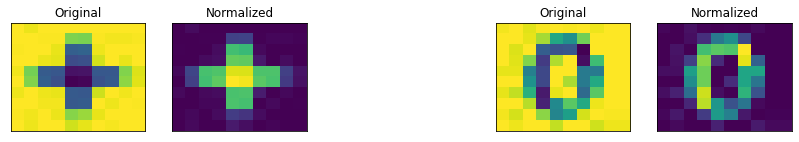

In [3]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter
from PIL import Image
import numpy as np

path1 = "+.jpg"
path2 = "o.jpg"

plt.figure(figsize=(14,2))
p = Plotter([
    ['im1','nim1',None,'im2','nim2'],
])
p.imshow('im1', Image.open(path1).convert('L'), title="Original")
p.imshow('im2', Image.open(path2).convert('L'), title="Original")

def normalize(path):
    im = np.array(Image.open(path).convert('L'))
    im = torch.from_numpy(im)
    im = 255 - im
    im = im.float()
    im /= im.float().sum()
    im -= im.min()
    im /= im.max()
    im *= 255
    return im

im1,im2 = normalize(path1),normalize(path2)
p.imshow('nim1', Image.fromarray(im1.byte().numpy()), title="Normalized")
p.imshow('nim2', Image.fromarray(im2.byte().numpy()), title="Normalized")
plt.show()

<div dir='rtl'>
دو تصویر بالا را به صورت متناوب به شبکه ورودی خواهیم داد. بین هر تعویض مدتی محدود فاصله زمانی با مقدار کمی نویز قرار خواهیم داد.
    <br/>
 <font color='red'>نحوه محاسبه‌ی پاداش به این صورت است که با تأخیر مشخصی (که مقدار آن بررسی خواهد شد، اما به صورت پیشفرض یک میلی ثانیه است)، هر لحظه را بررسی می‌کنیم. اگر نورون مربوط به آن تصویر فعالیت داشته باشد، یک امتیاز مثبت و اگر نورون دیگر فعالیت داشته باشد یک امتیاز منفی درنظر گرفته می‌شود. در بخش‌هایی که مدل درحال دریافت نویز است، شبکه به ازای هر فعالیتی یک امتیاز منفی دریافت خواهد کرد. این نحوه پاداش‌دهی بهترین نتیجه را داشته است.</font>
    <br/>
    یک روش پاداش دهی دیگر نیز آزموده شد که موفق نبود. این روش به این صورت بود که تا پایان یک دوره مشاهده تصویر هیچ یادگیری انجام نمی‌شود و هربار در بازه مشاهده نویز، یادگیری مربوط به تصویر قبل انجام می‌شد. در این حالت، مدل در هر مرحله نتیجه مرحله قبل را پیشبینی می‌کرد. دلیل این امر واضح است. به علت ناهمگامی آموزش با مشاهدات، مدل توانایی یافتن الگو را نداشت. همچنین پاداش‌های دیگری (از جمله پاداش مجازات اندکی برای هر گام زمانی) نیز امتحان شد که نتایج خوبی نداشتند.
    <br/>
 <font color='red'>نحوه تصمیم گیری مدل به این صورت است که پس از پایان یک دوره مشاهده تصویر، طبقه‌ای پیشبینی می‌شود که نورون مربوط به آن در بازه مذکور فعالیت بیشتری داشته است.</font>
</div>

In [4]:
from cnsproject.monitors.monitors import Monitor

def reward(expected, activities):
    y0, y1 = activities
    y0, y1 = int(y0), int(y1)
    reward = 0
    if expected==-1:
        reward -= y0+y1
    elif expected==0:
        reward += y0-y1
    elif expected==1:
        reward += y1-y0
    return reward

x = []
def predict(monitor, step_time):
    global x
    x.append(monitor['output_spikes'][-step_time:])
    avtivities = monitor['output_spikes'][-step_time:].sum(axis=0)
    return avtivities.argmax()

def simulate(net, step_time = 100, step_count = 12, delay = 1):
    net.reset()
    monitor = Monitor(net, state_calls={
        'encoder_spikes': net['encoder'].spikes,
        'output_spikes': net['output'].spikes,
        'dopamine': net[['dopaminergic-tissue']].activity,
    }, time=step_time)
    dendrite_monitor = Monitor(net[[['synapse']]].dendrite, state_variables=['w'])
    monitor.reset(), dendrite_monitor.reset()
    net.reset()
    ims = [im1,im2]
    predictions = []
    for i in range(step_count):
        
        def run(expected, **args):
            if len(monitor['output_spikes'])>=delay:
                avtivities = monitor['output_spikes'][-delay]
                net[['dopaminergic-tissue']].feedback(reward(expected, avtivities))
            net.run(**args
                   )
        net['encoder'].encode(ims[i%2])
        monitor.simulate(run, inputs={"expected": [i%2]}, attendance=[dendrite_monitor], reset=False)
        predictions.append(ims[predict(monitor, step_time)])
        # noise
        net['encoder'].encode(im1*0)
        monitor.simulate(run,
                         inputs={"encoder_clamp": torch.rand(int(step_time//3), *net['encoder'].output_shape)>.98,
                                "expected": [-1]},
                         attendance=[dendrite_monitor],
                         time=int(step_time//3), reset=False)
    return monitor,dendrite_monitor,predictions

In [5]:
def plot_every_thing(monitor, dendrite_monitor, predictions, steps = 12, name = ''):
    ims = [im1,im2]
    plt.figure(figsize=(14,10))
    p = Plotter([
        ['output']*steps,
        [f'pr{i}' for i in range(steps)],
        ['weights']*steps,
        ['weights']*steps,
        ['dopamine']*steps,
        ['dopamine']*steps,
        [f'im{i}' for i in range(steps)],
        ['encode']*steps,
        ['encode']*steps,
    ], monitor=monitor, wspace=0.3)
    for i in range(steps):
        y_label = "Input" if i==0 else ""
        p.imshow(f'im{i}', ims[i%2], y_label=y_label, cmap='YlGn', interpolation='nearest')
        y_label = "Predicted" if i==0 else ""
        p.imshow(f'pr{i}', predictions[i], y_label=y_label, cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('encode', y='encoder_spikes', y_label='encoding', alpha=.3, x_lim='fit')
    p.population_plot('weights', y='w', y_label="weights", monitor=dendrite_monitor, aggregation=None,
                      population_alpha=.05, x_lim='fit', x_vis=False)
    p.plot('dopamine', y='dopamine', y_label="dopamine", x_lim='fit', x_vis=False)
    p.population_activity_raster('output', y='output_spikes', y_label='outputs', s=5, y_lim=(-1,2),
                                 x_lim='fit', title=name, x_vis=False)
    p.show()

<a id='3'></a>
<div dir='rtl'>
<h2>3. روش RSTDP</h2>
    <br/>
    از مشاهده عملکرد این روش شروع می‌کنیم.
</div>

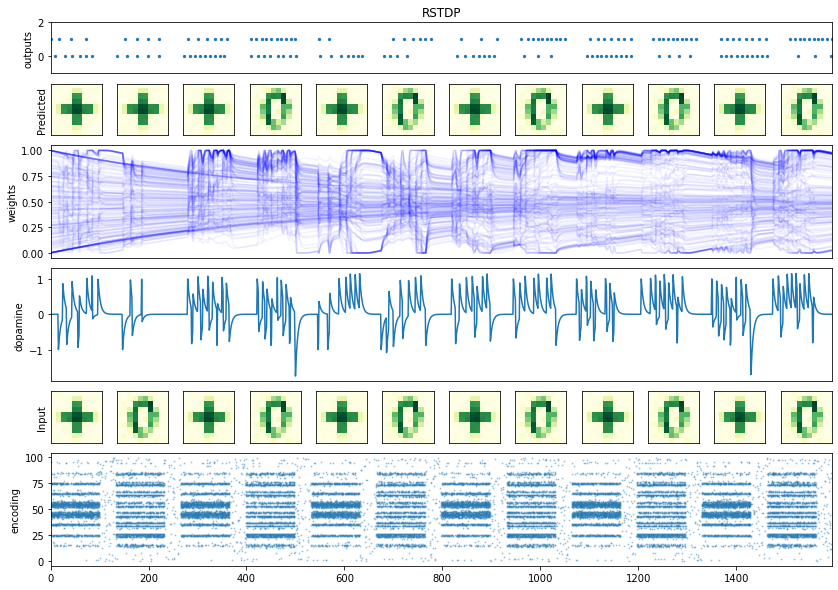

In [443]:
net = build_rstdp_net(tau=100., dopaminergic_tau=5., dopaminergic_scale=.5)
result = simulate(net)
plot_every_thing(*result, name="RSTDP")

<div dir='rtl'>
    در آموزش فوق، از decay به سمت مرکز استفاده کردیم که وزن‌ها را متمایل به میانه‌ی بازه‌ی مجازشان سوق می‌دهد. پس حدود ۲۰ ساعت آزمون و خطا، به پارامتر‌های مناسبی برای آموزش شبکه دست پیدا کردیم. می‌توان مشاهده کرد که برخی از وزن‌ها طی آموزش فقط به سمت مرکز حرکت می‌کنند. این وزن‌ها وزن‌های بی‌تأثیرند (مثلا مربوط به حاشیه عکس‌ها). همچنین برخی وزن‌ها همیشه روند تغییرات یکسانی دارند. این وزن‌ها مربوط به پیکسل‌های مشترک بین دو تصویرند. وزن‌هایی که تغییرات آن‌ها بسته به عکس ورودی است، وزن‌های تأثیر گذارند. ارتباط بین غلظت دوپامین و پیشگویی مدل کاملا واضح است.
</div>

<a id='4'></a>
<div dir='rtl'>
<h2>4. تأثیر پارامتر ثابت زمانی تغییرات دوپامین در روش RSTDP</h2>
    <br/>
    این پارامتر میزان لختی غلظت دوپامین را مشخص می‌کند. با زیاد شدن این لختی، ماندگاری دوپامین‌ها زیاد شده و با توجه به جمع‌پذیری آثار این ذره، یادگیری را تشدید می‌کند.
</div>

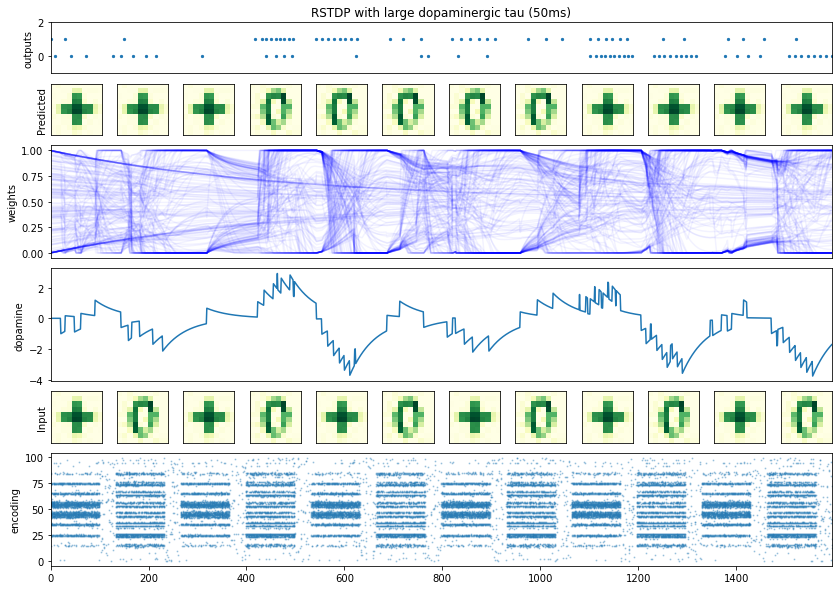

In [444]:
net = build_rstdp_net(tau=100., dopaminergic_tau=50., dopaminergic_scale=.5)
result = simulate(net)
plot_every_thing(*result, name="RSTDP with large dopaminergic tau (50ms)")

<div dir='rtl'>
مشاهده می‌کنیم که (همانطور که گفته شد) تغییرات دوپامین کند‌تر صورت گرفته و تغییرات وزن‌ها شدید‌تر شده است. به دلیل کاهش دقت یادگیری (در نتیجه‌ی تشدید تغییرات)، عملکرد شبکه تضعیف شده است.
</div>

<a id='5'></a>
<div dir='rtl'>
<h2>5. تأثیر پارامتر مقیاس تآثیرگذاری دوپامین در RSTDP</h2>
    <br>
    این پارامتر به سادگی مقیاس پاداش را تغییر می‌دهد. مشخصا هرچه مقدار این پارامتر بزرگ‌تر شود، میزان تغییرات بزرگ‌تر می‌شود. به نوعی می‌توان از آن به عنوان نرخ آموزشی استفاده کرد.
</div>

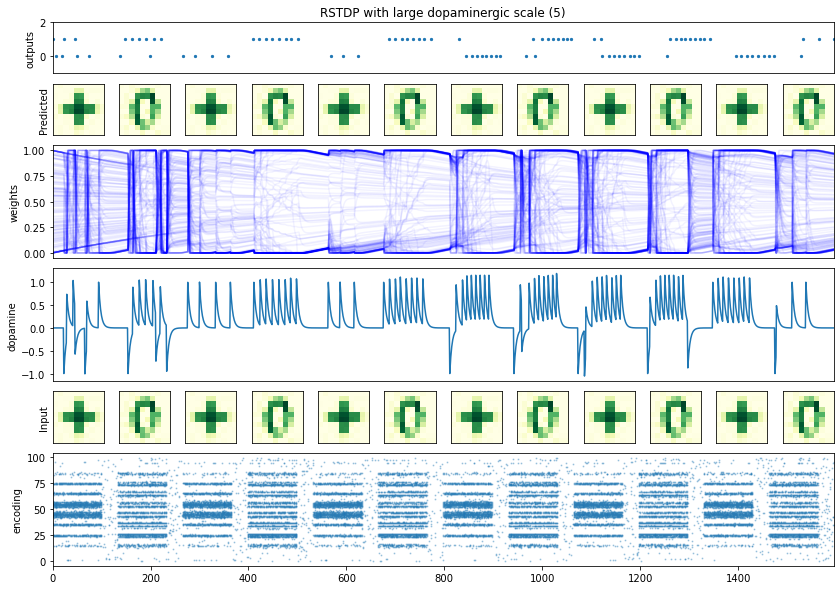

In [445]:
net = build_rstdp_net(tau=100., dopaminergic_tau=5., dopaminergic_scale=5)
result = simulate(net)
plot_every_thing(*result, name="RSTDP with large dopaminergic scale (5)")

<div dir='rtl'>
    مشاهده می‌کنیم با گام آموزشی بزرگ، تغییرات شدید‌تر و نا دقیق‌تر می‌شوند. با اینحال می‌بینیم که نقطه همگرایی یادگیری نقطه‌ای صحیح و حتی بهتر از نسخه آورده شده در ابتدای گزارش است. دلیل این امر سادگی مسئله تعریف شده است. چون نیاز به دقت به جزئیات نیست، با گام‌های بزرگ نیز تفاوت‌ها قابل شناسایی هستند و مدل به این روش سریع‌تر یادگیری را انجام می‌دهد. همچنین به نقطه شروع یادگیری نیز باید توجه شود. یکی از عمده دلایلی که در این نمودار می‌بینیم شبکه عملکرد موفقیت آمیزی داشته، نقطه شروع مناسب آن بوده است. مدل تقریبا از بتدا موفق بوده است و حفظ این موفقیت از بدست آوردن آن ساده‌تر می‌باشد. بنابراین ممکن است با اجرای دوباره این آزمایش نتیجه متفاوتی بدست آوریم. این مسئله را بررسی می‌کنیم:
</div>

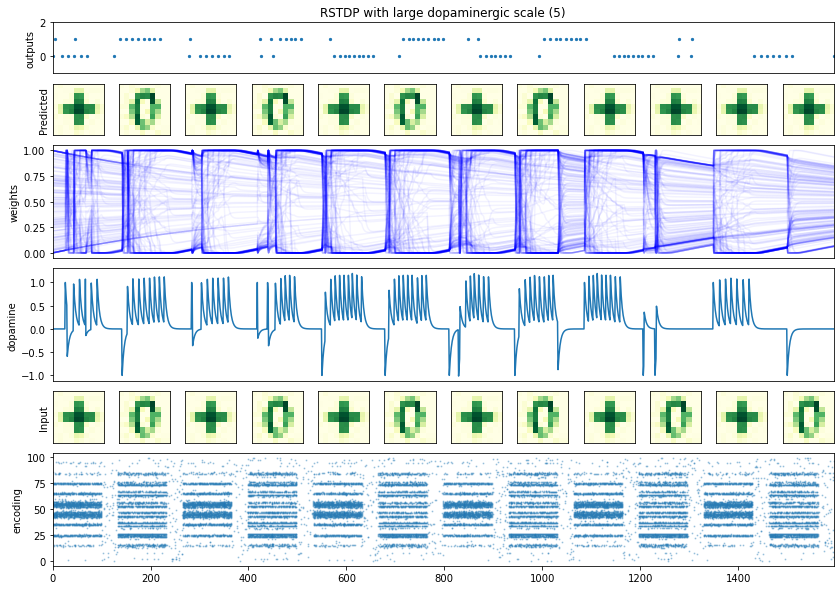

In [446]:
net = build_rstdp_net(tau=100., dopaminergic_tau=5., dopaminergic_scale=5)
result = simulate(net)
plot_every_thing(*result, name="RSTDP with large dopaminergic scale (5)")

<div dir='rtl'>
همانطور که حدس زده بودیم، گام‌های بزرگ باعث افزایش اثرات تصادفی بر یادگیری می‌شوند و یادگیری مدل در خطر خواهد بود.
</div>

<a id='6'></a>
<div dir='rtl'>
<h2>6. تأثیر پارامتر ثابت زمانی در روش RSTDP</h2>
    <br>
    افزایش این پارامتر باعث افزایش لختی دینامیک اصلی این روش شده و در نتیجه، افزایش لختی تغییرات وزن‌ها را در پی خواهد داشت (توجه کنید افزایش لختی تغییرات به معنی کند شدن تغییر تغییرات است نه کند شدن تغییرات، بنابراین شیب نمودار وزن‌ها به سختی تغییر خواهد کرد).
</div>

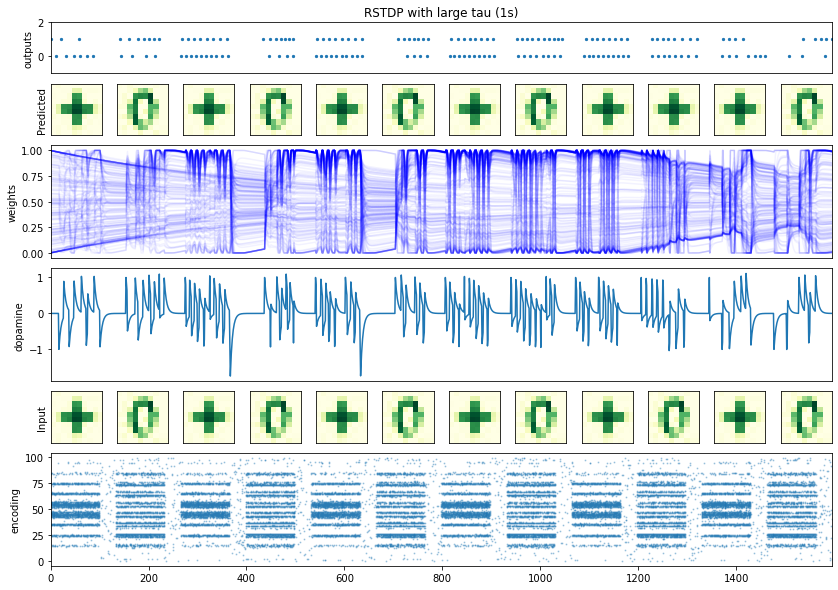

In [447]:
net = build_rstdp_net(tau=1000., dopaminergic_tau=5., dopaminergic_scale=.5)
result = simulate(net)
plot_every_thing(*result, name="RSTDP with large tau (1s)")

<div dir='rtl'>
همانطور که انتظار داشتیم، شیب نمودار وزن‌ها به سختی تغییر می‌کند و در نتیجه نمودار منظم‌تری را شاهد هستیم. مقدار این پارامتر باید متناسب با دیگر پارامتر‌های زمانی باشد. مشاهده می‌کنیم که مقدار بیش از اندازه بزرگ آن باعث اختلال در یادگیری شده است. توجیه این اختلال بسیار آسان است. افزایش لختی تغییرات یعنی اگر در این لحظه نیازمند تغییر شدیدی هستیم، این تغییر را باید تا مدت طولانی‌ای ادامه دهیم و در نتیجه، اگر در ادامه، با تغییر ورودی دیگر نیازی به تغییر قبلی نداشته باشیم، توانایی لغو آن را نداریم و به این صورت در یادگیری اختلال ایجاد می‌شود.
</div>

<a id='7'></a>
<div dir='rtl'>
<h2>7. میزان تأخیر پاداش‌دهی</h2>
    <br>
در مسائل واقعی، این یک پارامتر قابل تنظیم نیست بلکه به دلیل عدم آگاهی از پاداش‌های لحظه‌ای از آن استفاده می‌شود. به صورت کلی بهتر است مدل در هر لحظه پاداش مربوط به تصمیم آن لحظه را دریافت کند تا بتواند دقیق‌تر وزن‌های متأثر را تغییر دهد. در این بخش قصد داریم بررسی کنیم اگر چنین امکانی وجود نداشته باشد، یادگیری مدل با چه مشکلاتی روبرو می‌شود. هز دوره مشاهده یک عکس ۱۰۰ میلی ثانیه است. تأخیر مذکور را برابر ۲۰ میلی ثانیه درنظر می‌گیریم.
</div>

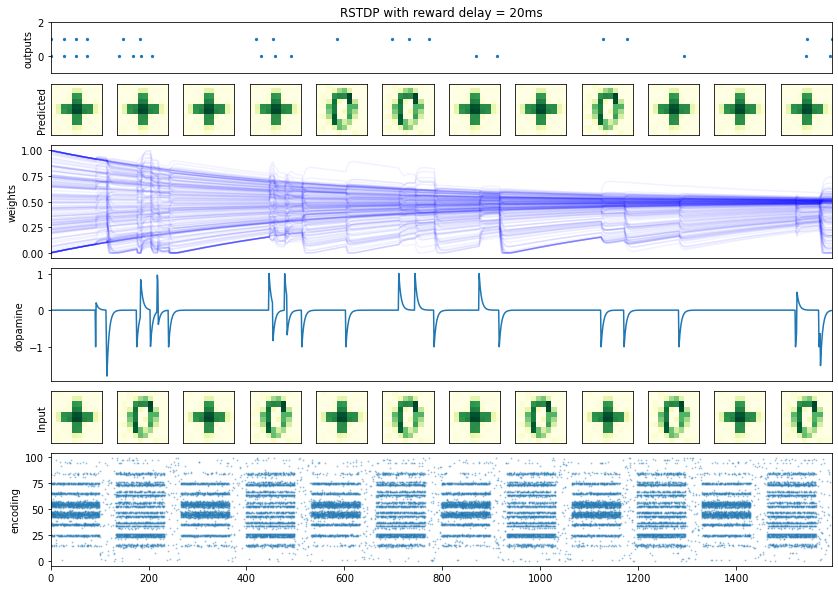

In [448]:
net = build_rstdp_net(tau=100., dopaminergic_tau=5., dopaminergic_scale=.5)
result = simulate(net, delay=20)
plot_every_thing(*result, name="RSTDP with reward delay = 20ms")

<div dir='rtl'>
مشاهده می‌کنیم که تغییرات به صورت بسیار ضعیفی اعمال می‌شوند و به این صورت، یادگیری مختل می‌شود. دلیل این امر در فرمول مربوط به RSTDP قابل مشاهده است. با طی زمان تأخیر، دینامیک c در فرمول باعث کاهش این مقدار شده و در نتیجه، مقدار تغییرات وزن‌ها کاهش پیدا می‌کند. انتظار می‌رود با افزایش لختی c (افزایش ثابت زمانی RSTDP) باعث افزایش تغییرات شویم:
</div>

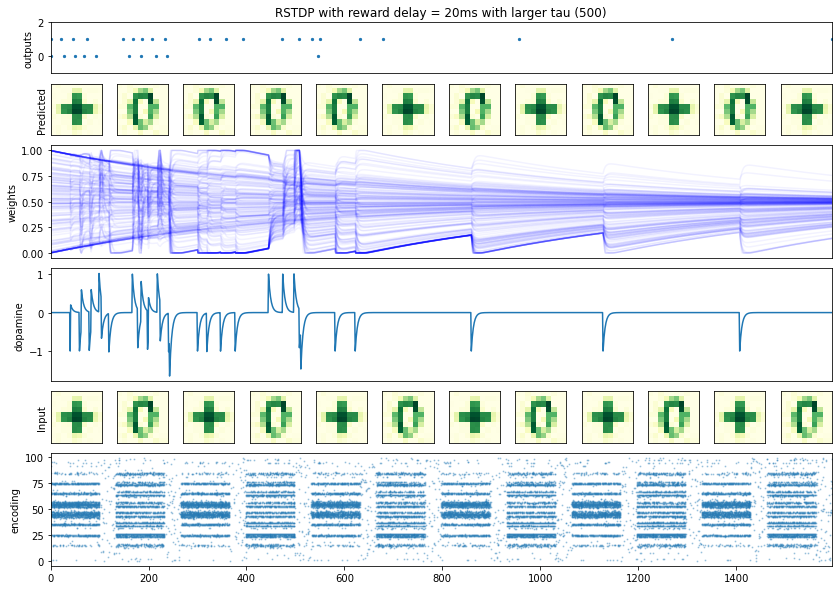

In [449]:
net = build_rstdp_net(tau=500., dopaminergic_tau=5., dopaminergic_scale=.5)
result = simulate(net, delay=20)
plot_every_thing(*result, name="RSTDP with reward delay = 20ms with larger tau (500)")

<div dir='rtl'>
همانطور که پیشبینی می‌کردیم، تآخیرات شدید‌تر شده اما یادگیری همچنان ضعیف است. دلیل آن است که با وجود تأخیر، شبکه به اشتباه سعی بر اعمال پاداش بر مقادیر نویز دارد. با توجه به اینکه در این مسئله، مقدار نویز بالاست (هم روش کد گذاری نویز دار است هم مابین تصاویر نویز قرار داده شده است)، وجود تأخیر مشکلات فراوانی بوجود می‌آورد.
</div>

<a id='8'></a>
<div dir='rtl'>
<h2>8. روش Flat-RSTDP</h2>
</div>

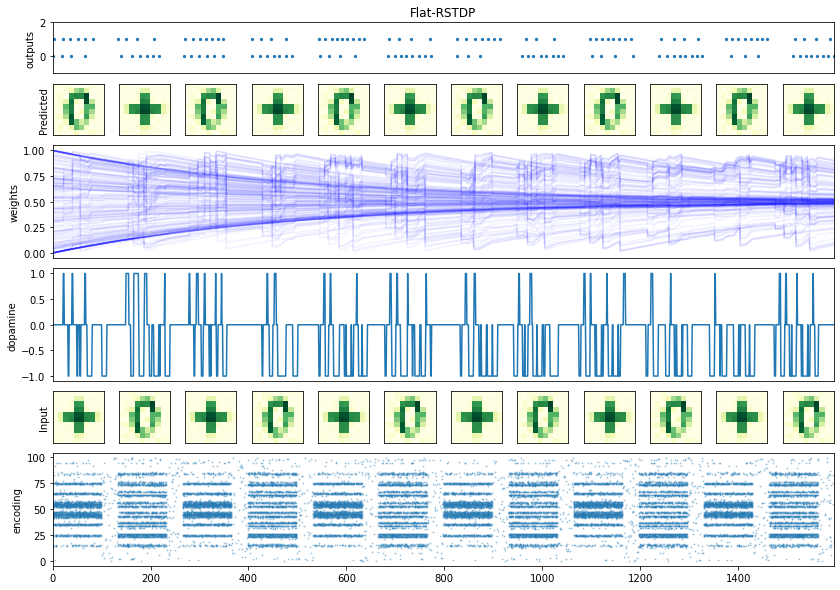

In [46]:
net = build_flat_rstdp_net(time_window=10., dopaminergic_scale=.2)
result = simulate(net)
plot_every_thing(*result, name="Flat-RSTDP")

<div dir='rtl'>
مشاهده می‌کنیم که این مدل دچار خطای زیادی در یادگیری شده است. این مشکل به دلیل عدم هماهنگی ثابت‌های زمانی است. با کمی آزمون و خطا به پارامتر‌های زیر رسیدیم که این مشکل را برطرف می‌کند:
</div>

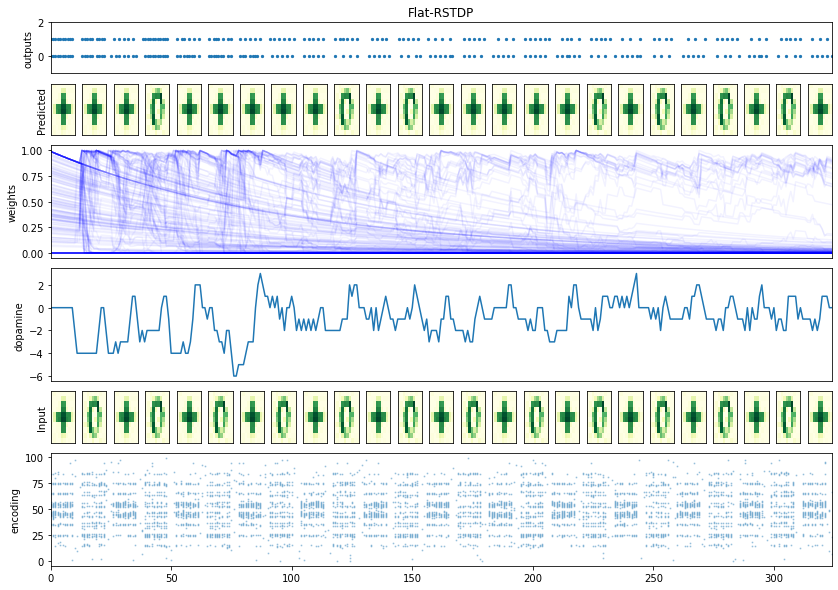

In [40]:
net = build_flat_rstdp_net(time_window=10.,
                           dopaminergic_scale=1,
                           scale=75,
                           decay_method=SimpleWeightDecayLRE,
                           decay=0.01,
                           pre_time=10,
                           post_time=10
                          )
result = simulate(net, step_time=10, step_count=25)
plot_every_thing(*result, name="Flat-RSTDP", steps=25)

<div dir='rtl'>
شاهد یادگیری این مدل بعد از طی تعداد بیشتری تصویر هستیم. توجه کنید که در این آزمایش هر تصویر فقط ۱۰۰ میلی ثانیه نمایش داده شده است، بنابراین زمان آزمایش کوتاه‌تر از قبل است. واضح است که تناسب زمان بندی اجزای مختلف شبکه بر عملکرد آن تأثیر شگرفی دارد.
</div>

<a id='9'></a>
<div dir='rtl'>
<h2>9. تأثیر پارامتر پنجره Flat-RSTDP</h2>
    <br/>
    انتظار می‌رود این اثر مانند اثر tau در RSTDP باشد.
</div>

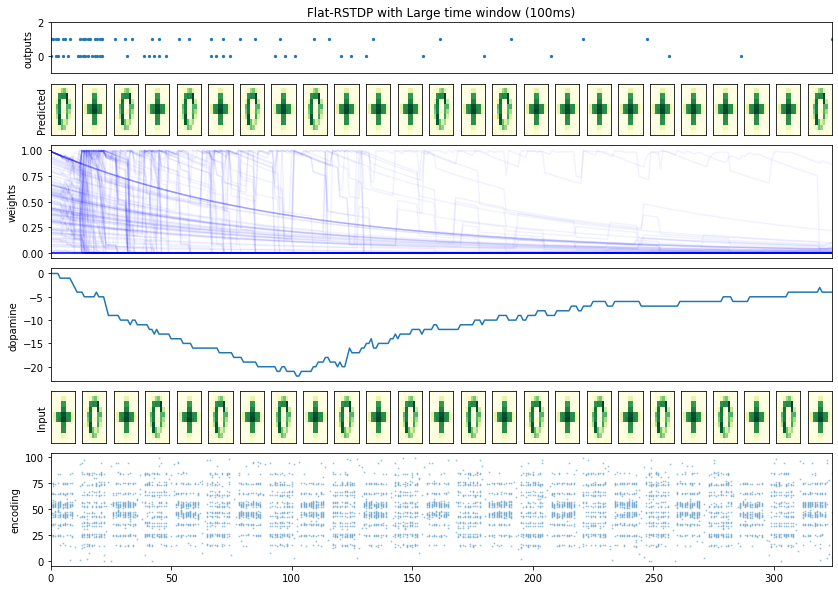

In [47]:
net = build_flat_rstdp_net(time_window=100., dopaminergic_scale=1, scale=75, decay=0.01,
                           decay_method=SimpleWeightDecayLRE)
result = simulate(net, step_time=10, step_count=25)
plot_every_thing(*result, name="Flat-RSTDP with Large time window (100ms)", steps=25)

<div dir='rtl'>
شاهد نتایج مورد انتظار هستیم. تفاوت دیگری که وجود دارد این است که در این آزمایش چون از نزول به صفر استفاده شده است، فرکانس خروجی میرا می‌شود و چون میزان دوپامین به مقادیر خیلی منفی کاهش پیدا کرده است، توانایی جبران این نزول از مدل گرفته شده است
</div>